## Importing libraries and functions

In [82]:
# Standard data manipulation and visualization libraries
import pandas as pd                 
import matplotlib.pyplot as plt     
import numpy as np                  
import seaborn as sns               
import os                           

# Natural Language Processing libraries
from tensorflow.keras.preprocessing.text import Tokenizer                                                        
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # For text vectorization
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report  # For model evaluation

# For deep learning
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding          
from tensorflow.keras.initializers import Constant                          
from tensorflow.keras.preprocessing.sequence import pad_sequences          
from tensorflow.keras.utils import to_categorical                           
from tensorflow.keras.models import Model, Sequential                      
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D  
import keras
from keras import layers
from keras import ops

import warnings               
warnings.filterwarnings("ignore") 

In [6]:
def evaluate_model(X_test, y_test, model):
    labels_index = {'Extremely Positive': 4, 'Positive': 3, 'Neutral': 2, 'Negative': 1, 'Extremely Negative': 0}
    # Define the class labels
    labels = list(labels_index.keys())

    # Make predictions
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
    recall = recall_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))

    # Classification report
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

## Importing datasets

In [7]:
df_train = pd.read_csv("/kaggle/input/cl-covid/aug_train.csv") # Augmented dataset
df_valid = pd.read_csv("/kaggle/input/cl-covid/cl_valid.csv")
df_test = pd.read_csv("/kaggle/input/cl-covid/cl_test.csv")

In [8]:
df_train = df_train.rename(columns={'clean_text': 'tweet'})[['tweet', 'sentiment']]
df_valid = df_valid.rename(columns={'clean_text': 'tweet'})[['tweet', 'sentiment']]
df_test = df_test.rename(columns={'clean_text': 'tweet'})[['tweet', 'sentiment']]
df_train.shape, df_valid.shape, df_test.shape
display(df_train.head())

tweet sentiment
0  supply run low income opportunity decrease nee...  Positive
1  factory perfume shirt car make supply fight ma...  Negative
2  aleaprotect choice include Law Enforcement Loc...   Neutral
3  Big Issue british paper sell homeless vulnerab...  Negative
4  die visit self went work shop time week elderl...   Neutral

In [9]:
# dropping null values
df_train.dropna(inplace = True)
df_valid.dropna(inplace = True)
df_test.dropna(inplace = True)

In [10]:
# Define the labels index dictionary
labels_index = {'Extremely Positive': 4, 'Positive': 3, 'Neutral': 2, 'Negative': 1, 'Extremely Negative': 0}

# Map sentiment text to labels index in datasets
df_train['sentiment_n'] = df_train['sentiment'].map(labels_index)
df_valid['sentiment_n'] = df_valid['sentiment'].map(labels_index)
df_test['sentiment_n'] = df_test['sentiment'].map(labels_index)

df_train.head()

tweet sentiment  sentiment_n
0  supply run low income opportunity decrease nee...  Positive            3
1  factory perfume shirt car make supply fight ma...  Negative            1
2  aleaprotect choice include Law Enforcement Loc...   Neutral            2
3  Big Issue british paper sell homeless vulnerab...  Negative            1
4  die visit self went work shop time week elderl...   Neutral            2

In [11]:
X_train = df_train.tweet
y_train = df_train.sentiment_n
X_valid = df_valid.tweet
y_valid = df_valid.sentiment_n
X_test = df_test.tweet
y_test = df_test.sentiment_n

In [12]:
X_train[0], y_train[0]

('supply run low income opportunity decrease need social distancing continue government extend reopen hunting fishing season obviously reasonable level joke',
 3)

## Vectorize

### Count vectorizer

Converting text data into numerical vectors by counting the occurrences of each word in the text corpus. Does not capture the semantic meaning of words and may not perform optimally with highly dimensional or sparse data.

In [13]:
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

### TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) assigns higher weights to words that are frequent in a document but rare across documents, thus capturing the importance of words in distinguishing documents. helps mitigate the impact of common words that occur frequently across documents.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train)

TfidfVectorizer()

## Scoring Metrics

Choice of metrics:

The following metrics will be considered since we do not have the clear business understanding of which class is important or misidentification of which class is more costly:

    - 1. Accuracy: Gives quick view of model's effectiveness across all classes.
    - 2. Precision (per class and average): Important for understanding how well the model predicts each class without labeling too many negatives as positives, crucial for - classes like 'Extremely Negative' where misclassifications can be more severe.
    - 3. Recall: Vital for ensuring that the model is capable of capturing the majority of positive samples in each class.
    - 4. Confusion Matrix: For instinsic analysis of mislabeling.

ROC AUC can be utilized if I take one-vs rest approach leaving it for now. 
Will not use F1-score as we have balanced the classes and calculating Precision and Recall separately as well.

## Machine Learning

### Naive Bayes model

#### Count Vectorizer

In [15]:
# Using count vectorizer
X_train_dtm = vect.transform(X_train)
X_valid_dtm = vect.transform(X_valid)
X_test_dtm = vect.transform(X_test)

X_train_dtm.shape, X_valid_dtm.shape, X_test_dtm.shape

((42367, 34194), (10275, 34194), (3793, 34194))

In [16]:
from sklearn.naive_bayes import MultinomialNB
# Define the model
model = MultinomialNB()

# Define the hyperparameters to tune
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False],  
    'class_prior': [None, [0.2, 0.2, 0.2, 0.2, 0.2]]  
}

from sklearn.model_selection import GridSearchCV

# Grid search 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy') # kept scoring as accuracy here
grid_search.fit(X_train_dtm, y_train)

best_params = grid_search.best_params_

# Retraining the model with the best hyperparameters
best_model = MultinomialNB(**best_params)
best_model.fit(X_train_dtm, y_train)

y_pred = best_model.predict(X_valid_dtm)

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'alpha': 0.1, 'class_prior': None, 'fit_prior': True}


Accuracy: 0.4415571776155718
Precision: 0.44633162833188805
Recall: 0.4415571776155718

Classification Report:
                    precision    recall  f1-score   support

Extremely Positive       0.42      0.59      0.49      1317
          Positive       0.41      0.36      0.38      2513
           Neutral       0.57      0.45      0.50      1904
          Negative       0.42      0.36      0.38      2898
Extremely Negative       0.43      0.58      0.50      1643

          accuracy                           0.44     10275
         macro avg       0.45      0.47      0.45     10275
      weighted avg       0.45      0.44      0.44     10275



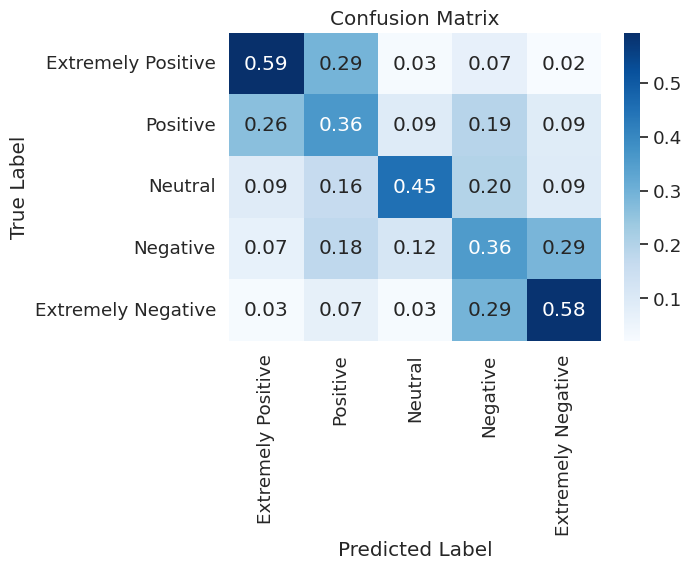

In [17]:
evaluate_model(X_valid_dtm, y_valid, best_model)

Accuracy: 0.414711310308463
Precision: 0.4149786911603948
Recall: 0.414711310308463

Classification Report:
                    precision    recall  f1-score   support

Extremely Positive       0.41      0.58      0.48       592
          Positive       0.40      0.35      0.37      1041
           Neutral       0.46      0.38      0.42       614
          Negative       0.37      0.35      0.36       947
Extremely Negative       0.48      0.50      0.49       599

          accuracy                           0.41      3793
         macro avg       0.42      0.43      0.42      3793
      weighted avg       0.41      0.41      0.41      3793



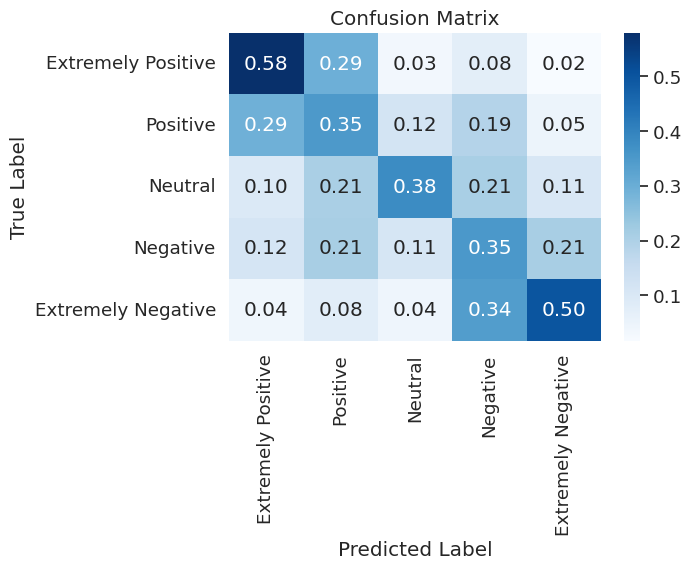

In [17]:
# Performance on test
evaluate_model(X_test_dtm, y_test, best_model)

The model performs best in classifying 'Extremely Positive' and 'Extremely Negative' sentiments, with higher precision and recall compared to other classes.

The 'Neutral' class has a relatively better precision of 46% but lower recall, suggesting the model is more conservative but more accurate when it predicts this class.

The model struggles with the 'Positive' and 'Negative' classes with both lower precision and recall, indicating both a higher number of false positives and a higher number of false negatives for these classes.

**Could also experiment with count_vectorizer hyperparameter tuning such as max_features.**

#### TF_IDF

In [18]:
# Using tf-idf vectorizer
X_train_dtm = tfidf_vect.transform(X_train)
X_valid_dtm = tfidf_vect.transform(X_valid)
X_test_dtm = tfidf_vect.transform(X_test)

X_train_dtm.shape, X_valid_dtm.shape, X_test_dtm.shape

((42367, 34194), (10275, 34194), (3793, 34194))

In [19]:
# Define the model
model = MultinomialNB()

# Define the hyperparameters to tune
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False],  
    'class_prior': [None, [0.2, 0.2, 0.2, 0.2, 0.2]]  
}

# Grid search 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy') # kept scoring as accuracy here
grid_search.fit(X_train_dtm, y_train)

best_params = grid_search.best_params_

# Retraining the model with the best hyperparameters
best_model = MultinomialNB(**best_params)
best_model.fit(X_train_dtm, y_train)

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'alpha': 0.1, 'class_prior': None, 'fit_prior': True}


Accuracy: 0.4327980535279805
Precision: 0.43893568029235497
Recall: 0.4327980535279805

Classification Report:
                    precision    recall  f1-score   support

Extremely Positive       0.41      0.59      0.49      1317
          Positive       0.40      0.36      0.38      2513
           Neutral       0.56      0.44      0.49      1904
          Negative       0.42      0.35      0.38      2898
Extremely Negative       0.41      0.56      0.47      1643

          accuracy                           0.43     10275
         macro avg       0.44      0.46      0.44     10275
      weighted avg       0.44      0.43      0.43     10275



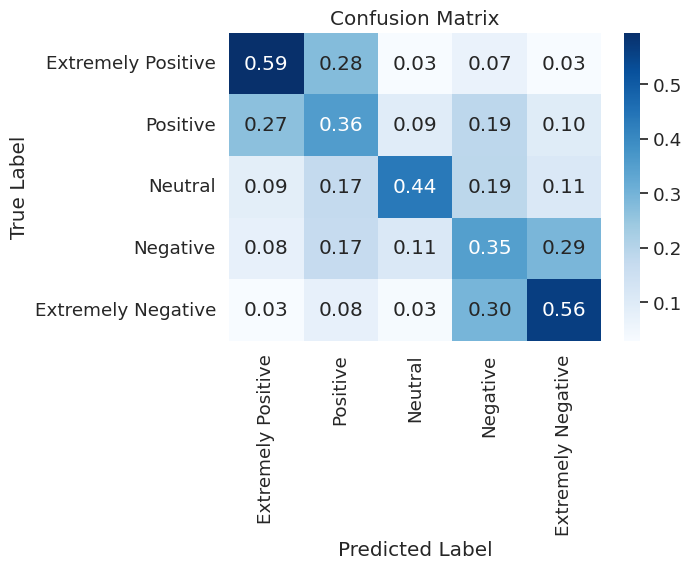

In [20]:
evaluate_model(X_valid_dtm, y_valid, best_model)

We have slightly low scores here using tf-idf over count-vectrizer probably because it penalises the words that have been used a lot hence words such as price may lose it's context here as they have a very high frequency but have a different meaning when used with words like low or high.  We can update the n-gram range and check the performance again. 

In [19]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 4))
tfidf_vect.fit(X_train)

TfidfVectorizer(ngram_range=(1, 4))

In [22]:
# Using tf-idf vectorizer
X_train_dtm = tfidf_vect.transform(X_train)
X_valid_dtm = tfidf_vect.transform(X_valid)
X_test_dtm = tfidf_vect.transform(X_test)

X_train_dtm.shape, X_valid_dtm.shape, X_test_dtm.shape

((42367, 1181915), (10275, 1181915), (3793, 1181915))

In [23]:
# Define the model
model = MultinomialNB()

# Define the hyperparameters to tune
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False],  
    'class_prior': [None, [0.2, 0.2, 0.2, 0.2, 0.2]]  
}

# Grid search 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy') # kept scoring as accuracy here
grid_search.fit(X_train_dtm, y_train)

best_params = grid_search.best_params_

# Retraining the model with the best hyperparameters
best_model = MultinomialNB(**best_params)
best_model.fit(X_train_dtm, y_train)

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'alpha': 0.1, 'class_prior': None, 'fit_prior': True}


Accuracy: 0.4545012165450122
Precision: 0.46179358151436206
Recall: 0.4545012165450122

Classification Report:
                    precision    recall  f1-score   support

Extremely Positive       0.42      0.62      0.50      1317
          Positive       0.43      0.39      0.41      2513
           Neutral       0.57      0.41      0.48      1904
          Negative       0.44      0.41      0.42      2898
Extremely Negative       0.46      0.56      0.50      1643

          accuracy                           0.45     10275
         macro avg       0.46      0.48      0.46     10275
      weighted avg       0.46      0.45      0.45     10275



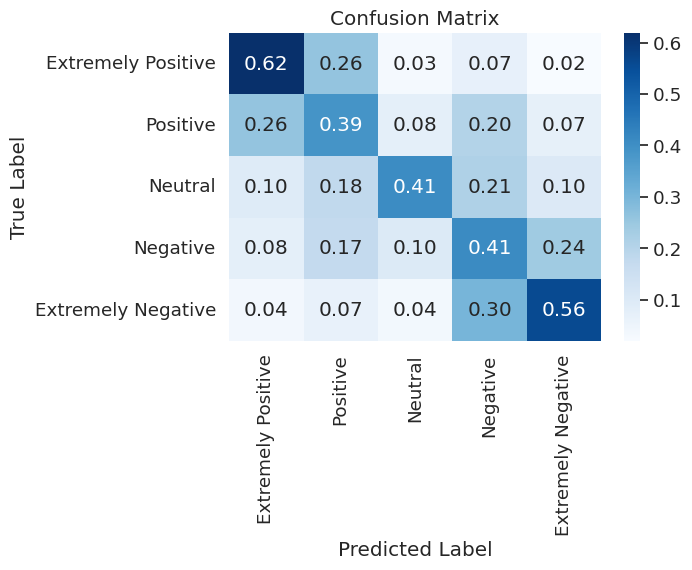

In [24]:
evaluate_model(X_valid_dtm, y_valid, best_model)

Updating the n-gram range does improve the model performance but it is still not great. We will try other models.

### Support Vector Machine

Using the same tf-idf vectors here.

In [25]:
from sklearn.svm import LinearSVC
model = LinearSVC()
model.fit(X_train_dtm, y_train)

LinearSVC()

Accuracy: 0.5226277372262774
Precision: 0.5421398938733472
Recall: 0.5226277372262774

Classification Report:
                    precision    recall  f1-score   support

Extremely Positive       0.48      0.76      0.59      1317
          Positive       0.56      0.37      0.45      2513
           Neutral       0.64      0.60      0.62      1904
          Negative       0.54      0.33      0.41      2898
Extremely Negative       0.45      0.81      0.58      1643

          accuracy                           0.52     10275
         macro avg       0.53      0.58      0.53     10275
      weighted avg       0.54      0.52      0.51     10275



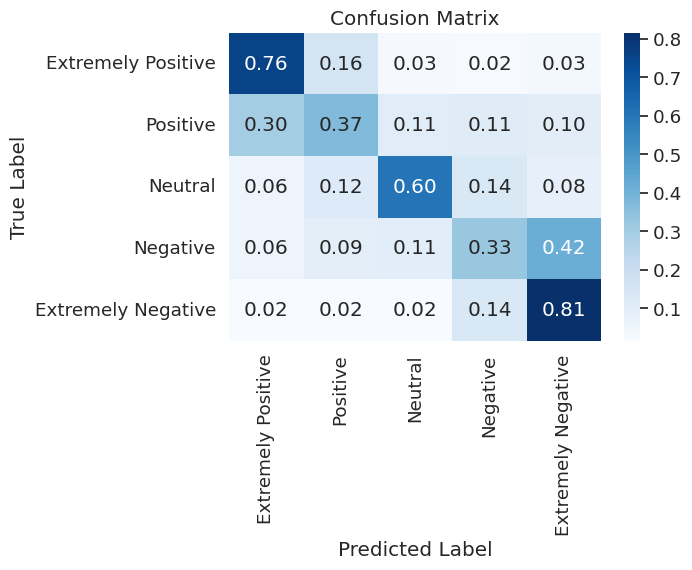

In [26]:
evaluate_model(X_valid_dtm, y_valid, model)

The model performance is better than the last one however, it's performance for Positive and Negative classes has still not improved. They are classified as Extremely Positive and Extremely Negative, respectively. 

Grid search was taking a lot of time so did some manual hyperparameter tuning.

In [27]:
model = LinearSVC(C = 1, multi_class='ovr')
model.fit(X_train_dtm, y_train)

LinearSVC(C=1)

Accuracy: 0.5226277372262774
Precision: 0.5421398938733472
Recall: 0.5226277372262774

Classification Report:
                    precision    recall  f1-score   support

Extremely Positive       0.48      0.76      0.59      1317
          Positive       0.56      0.37      0.45      2513
           Neutral       0.64      0.60      0.62      1904
          Negative       0.54      0.33      0.41      2898
Extremely Negative       0.45      0.81      0.58      1643

          accuracy                           0.52     10275
         macro avg       0.53      0.58      0.53     10275
      weighted avg       0.54      0.52      0.51     10275



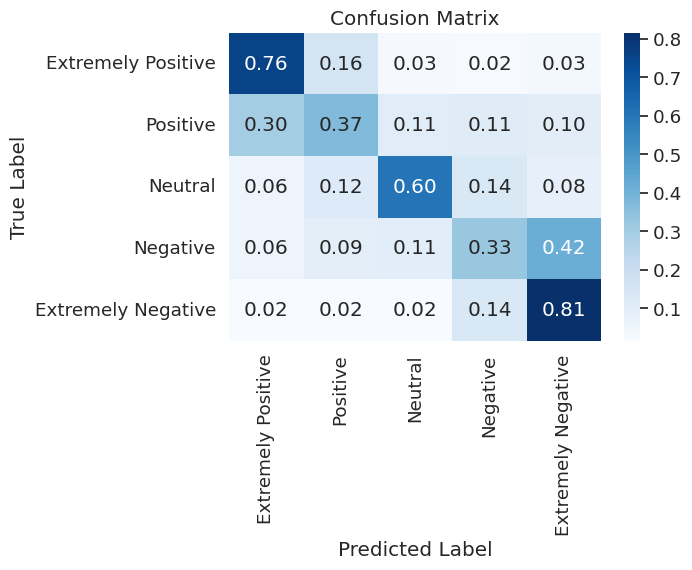

In [28]:
evaluate_model(X_valid_dtm, y_valid, model)

Default parameters were better. However there is still no improvement in positive and negative class predictions.

Haven't used SVC as it would takes more time to train due to complexity of kernal computations. Would try that if had more time. 

Instead going for ensemble methods, for now.

### LightGBM

In [20]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(random_state = 42)
model.fit(X_train_dtm, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.399709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133566
[LightGBM] [Info] Number of data points in the train set: 42367, number of used features: 3309
[LightGBM] [Info] Start training from score -1.626746
[LightGBM] [Info] Start training from score -1.603601
[LightGBM] [Info] Start training from score -1.609839
[LightGBM] [Info] Start training from score -1.603719
[LightGBM] [Info] Start training from score -1.603484


LGBMClassifier(random_state=42)

Accuracy: 0.5485158150851581
Precision: 0.5568276855079034
Recall: 0.5485158150851581

Classification Report:
                    precision    recall  f1-score   support

Extremely Positive       0.55      0.67      0.60      1317
          Positive       0.55      0.39      0.46      2513
           Neutral       0.51      0.85      0.64      1904
          Negative       0.59      0.38      0.46      2898
Extremely Negative       0.56      0.64      0.60      1643

          accuracy                           0.55     10275
         macro avg       0.55      0.59      0.55     10275
      weighted avg       0.56      0.55      0.53     10275



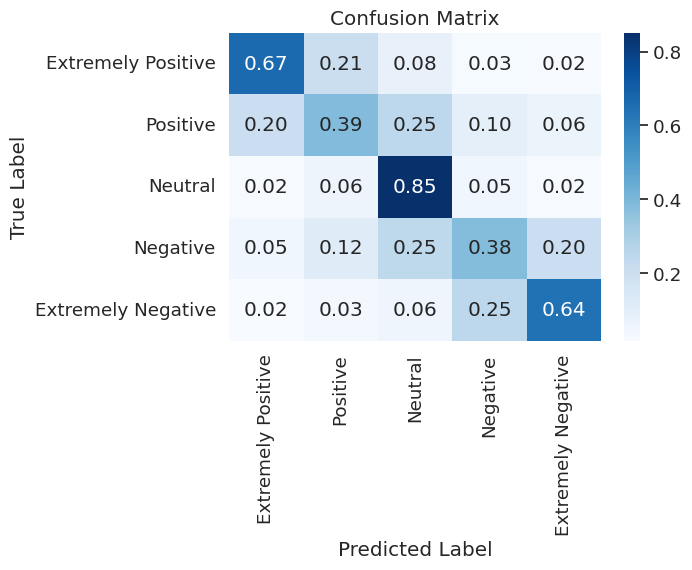

In [32]:
evaluate_model(X_valid_dtm, y_valid, model)

Same problem with the classes. However, here it has better performance for the neutral class whereas the positive and negative classes are mixed with the extremely positive and extremely negative.

In [21]:
model = LGBMClassifier(learning_rate=0.1, objective = 'multiclass', random_state = 42, n_estimators=200)
model.fit(X_train_dtm, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.392693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133566
[LightGBM] [Info] Number of data points in the train set: 42367, number of used features: 3309
[LightGBM] [Info] Start training from score -1.626746
[LightGBM] [Info] Start training from score -1.603601
[LightGBM] [Info] Start training from score -1.609839
[LightGBM] [Info] Start training from score -1.603719
[LightGBM] [Info] Start training from score -1.603484


LGBMClassifier(n_estimators=200, objective='multiclass', random_state=42)

Accuracy: 0.5635036496350365
Precision: 0.5668126053084598
Recall: 0.5635036496350365

Classification Report:
                    precision    recall  f1-score   support

Extremely Positive       0.57      0.69      0.62      1317
          Positive       0.56      0.41      0.47      2513
           Neutral       0.54      0.85      0.66      1904
          Negative       0.58      0.42      0.49      2898
Extremely Negative       0.60      0.61      0.61      1643

          accuracy                           0.56     10275
         macro avg       0.57      0.60      0.57     10275
      weighted avg       0.57      0.56      0.55     10275



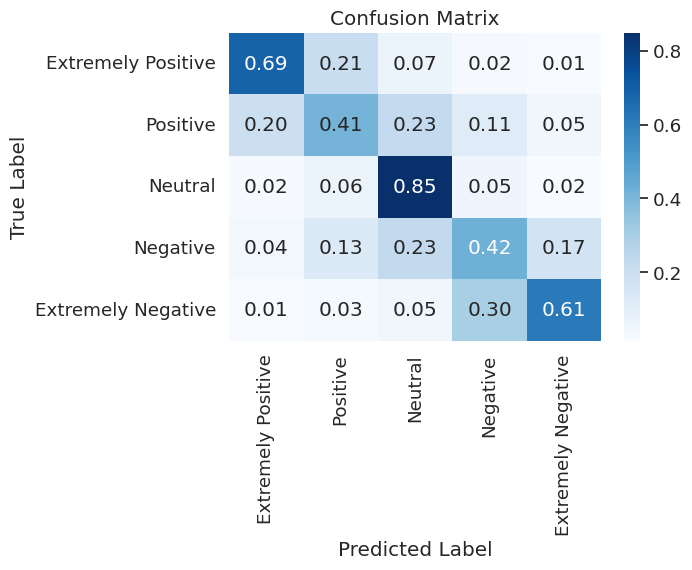

In [47]:
evaluate_model(X_valid_dtm, y_valid, model)

Accuracy: 0.5515423147904034
Precision: 0.5521972514276475
Recall: 0.5515423147904034

Classification Report:
                    precision    recall  f1-score   support

Extremely Positive       0.55      0.66      0.60       592
          Positive       0.54      0.40      0.46      1041
           Neutral       0.54      0.78      0.63       614
          Negative       0.56      0.41      0.47       947
Extremely Negative       0.57      0.69      0.62       599

          accuracy                           0.55      3793
         macro avg       0.55      0.59      0.56      3793
      weighted avg       0.55      0.55      0.54      3793



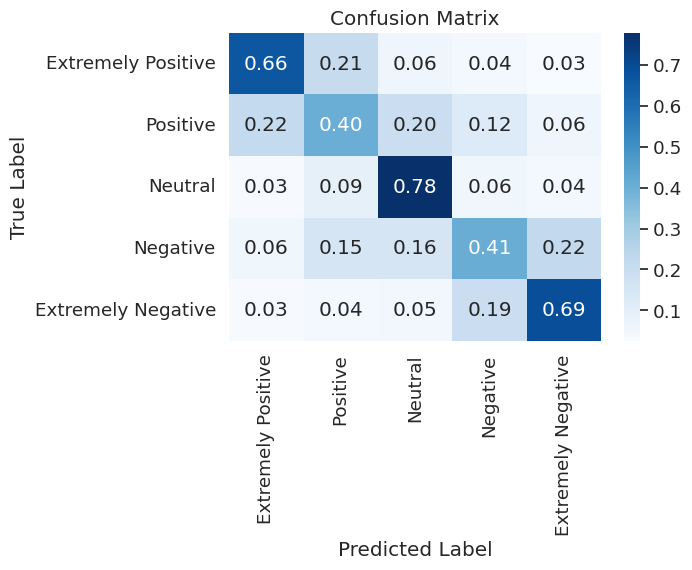

In [22]:
evaluate_model(X_test_dtm, y_test, model)

If the intensity of tweets is not relevant, I would combine Extremely Negative with Negative and Positive with Extremely Positive for better classification.

## Model Interpretability

### LIME

In [88]:
from sklearn.pipeline import make_pipeline
# Initialize a pipeline consisting of the vectorizer fitted previously and the lightgbm model trained previously
lgb_pipeline = make_pipeline(tfidf_vect, model)

In [89]:
from lime.lime_text import LimeTextExplainer
# Initialize a LimeTextExplainer with the class_names 
lime_lgb_explainer = LimeTextExplainer(class_names=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])

In [90]:
feature_names = tfidf_vect.get_feature_names_out()

In [102]:
# Assessing one sample
df_test.iloc[8]

tweet          HI TWITTER pharmacist sell hand sanitizer livi...
sentiment                                     Extremely Negative
sentiment_n                                                    0
Name: 8, dtype: object

In [101]:
sample_index = 8 
sample = X_test_dtm[sample_index]

selected_features = [(feature_names[i], i) for i in sample.indices]

for feature, index in selected_features:
    print(f"Feature: {feature}, Index: {index}")

sample_text = ' '.join([feature_names[i] for i in sample.indices])
lime_lgb_explainer.explain_instance(sample_text, lgb_pipeline.predict_proba, num_features=6).show_in_notebook(text=True)

Feature: worried, Index: 1169983
Feature: visit pharmacy, Index: 1118078
Feature: visit, Index: 1117525
Feature: use soap, Index: 1105594
Feature: use, Index: 1104009
Feature: twitter, Index: 1090688
Feature: soap, Index: 948846
Feature: sick, Index: 935750
Feature: sell hand sanitizer, Index: 900742
Feature: sell hand, Index: 900734
Feature: sell, Index: 900113
Feature: sanitizer, Index: 875562
Feature: pharmacy, Index: 733724
Feature: pharmacist, Index: 733553
Feature: mask sell, Index: 607719
Feature: mask, Index: 605187
Feature: look, Index: 581303
Feature: living, Index: 570277
Feature: like mask, Index: 558197
Feature: like, Index: 555566
Feature: hi, Index: 446054
Feature: hand sanitizer, Index: 421869
Feature: hand, Index: 419875
Feature: fuck, Index: 374714
Feature: exist like, Index: 320710
Feature: exist, Index: 320617
Feature: bottle, Index: 95626


Model predicts the text is most likely to be "Extremely Negative" which is the correct prediction. Despite the strong prediction for "Extremely Negative", the model also assigns non-negligible probabilities to "Positive" and "Extremely Positive" categories, suggesting some conflicting signals in the text. Words like "worried", "sick", and an expletive suggest negative sentiment, which likely contributes to the "Extremely Negative" prediction. However, the presence of other words like "pharmacy", "soap", "hand sanitizer", and "mask" could be related to health and safety, which in a different context might be associated with more neutral or even positive sentiment. 

In [93]:
df_test.iloc[10]

tweet          best quality couch unbelievably low price avai...
sentiment                                               Positive
sentiment_n                                                    3
Name: 10, dtype: object

In [95]:
sample_index = 10 
sample = X_test_dtm[sample_index]

selected_features = [(feature_names[i], i) for i in sample.indices]

for feature, index in selected_features:
    print(f"Feature: {feature}, Index: {index}")

sample_text = ' '.join([feature_names[i] for i in sample.indices])
lime_lgb_explainer.explain_instance(sample_text, lgb_pipeline.predict_proba, num_features=6).show_in_notebook(text=True)

Feature: whatsapp, Index: 1147389
Feature: unbelievably, Index: 1094315
Feature: sayentrepreneur, Index: 886640
Feature: quality, Index: 803536
Feature: price available, Index: 765848
Feature: price, Index: 765216
Feature: order, Index: 695496
Feature: low price, Index: 589424
Feature: low, Index: 588220
Feature: info, Index: 497410
Feature: gp, Index: 405666
Feature: djsbu, Index: 266273
Feature: couch, Index: 198815
Feature: boksburg, Index: 92771
Feature: best, Index: 83900
Feature: available order, Index: 62589
Feature: available, Index: 61853


The model is most confident that the text is "Extremely Positive" with a probability of 0.59. The words closer to the Negative for example "low" likely contributed to a more negative prediction, while words closer to the "NOT Negative" side "best" contributed to a less negative (more positive) prediction. However, there is also a feature: low price, that has significantly added to the prediction. However, the actual value is Positive but the prediction is Extremely Positive due to the presence of words best and quality.

In [108]:
df_test.iloc[61]

tweet          BreakingNews terrorist watch closely spin web ...
sentiment                                     Extremely Negative
sentiment_n                                                    0
Name: 61, dtype: object

In [109]:
sample_index = 61 
sample = X_test_dtm[sample_index]

selected_features = [(feature_names[i], i) for i in sample.indices]

for feature, index in selected_features:
    print(f"Feature: {feature}, Index: {index}")

sample_text = ' '.join([feature_names[i] for i in sample.indices])
lime_lgb_explainer.explain_instance(sample_text, lgb_pipeline.predict_proba, num_features=6).show_in_notebook(text=True)

Feature: wipe ass, Index: 1151577
Feature: wipe, Index: 1151543
Feature: web, Index: 1138651
Feature: watch, Index: 1131513
Feature: value, Index: 1108370
Feature: toiletpaper factory, Index: 1066165
Feature: toiletpaper, Index: 1065602
Feature: toilet paper, Index: 1063751
Feature: toilet, Index: 1063415
Feature: terrorist, Index: 1034414
Feature: stock, Index: 985635
Feature: spin, Index: 962939
Feature: rush buy, Index: 866671
Feature: rush, Index: 866642
Feature: paper, Index: 714099
Feature: neglect, Index: 655026
Feature: know american, Index: 532348
Feature: know, Index: 532279
Feature: hostage, Index: 464424
Feature: hold, Index: 453996
Feature: film, Index: 348175
Feature: factory, Index: 331277
Feature: closely, Index: 164188
Feature: citizen, Index: 154949
Feature: buy toilet paper, Index: 115221
Feature: buy toilet, Index: 115218
Feature: buy, Index: 111449
Feature: breakingnews, Index: 100526
Feature: ass, Index: 55711
Feature: american, Index: 35882


Words such as "ass", "terrorist", "rush", "neglect", and "hostage" are typically associated with negative sentiments and are highlighted to different extents. However, other words like "value", "buy", and "stock" may be more ambiguous or even positive, depending on the context of covid as in stock was actually positive when things were out of stock and especially here when toilet paper is also mentioned. Despite the actual sentiment being "Extremely Negative", the model has given the highest probability to "Negative", which could be due to the presence of both negatively and neutrally connoted words. 

In [113]:
lime_lgb_explainer.explain_instance("hand sanitizer stock buy best", lgb_pipeline.predict_proba, num_features=6).show_in_notebook(text=True)

It has taken hand sanitizer has a positive word in terms of covid which was actually the case.

In [114]:
lime_lgb_explainer.explain_instance("worried sick death hospital", lgb_pipeline.predict_proba, num_features=6).show_in_notebook(text=True)

The model strongly predicts that the sentiment of the text is negative, with a significant leaning towards "Extremely Negative". The highlighted words suggest themes of concern and ill health, which are appropriately contributing to the negative sentiment classification. The absence of any "Extremely Positive" probability reinforces the grim tone of the text. This indicates that the model is potentially well-calibrated to detect negative sentiments in the context of a health crisis like COVID-19.

### SHAP

In [23]:
import shap
# filtering the data to the 50 most important features
X_test_nlp_samp_df = pd.DataFrame(shap.sample(X_test_dtm, 50).todense())
# we are using kmeans to summarize the ackground training data needed for shapley instead of using it all--> we
# we could instead of kmeans to sample some data points
x_summary = shap.kmeans(np.asarray(X_test_dtm.todense()), 10)
# Initialize a shapley kernel explainer, it needs the lgb_mdl.predict, a background training data,
shap_lgb_explainer = shap.KernelExplainer(model.predict,
                            x_summary)
# during the fitting, shapley regularizes the model with L1 such that it will only keep 20 features
shap_lgb_values_test = shap_lgb_explainer.shap_values(X_test_nlp_samp_df,
                                            l1_reg="num_features(20)")
shap.summary_plot(shap_lgb_values_test, X_test_nlp_samp_df,
            plot_type="dot", feature_names=tfidf_vect.get_feature_names_out())

  0%|          | 0/50 [00:00<?, ?it/s]

NameError: name 'vectorizer' is not defined

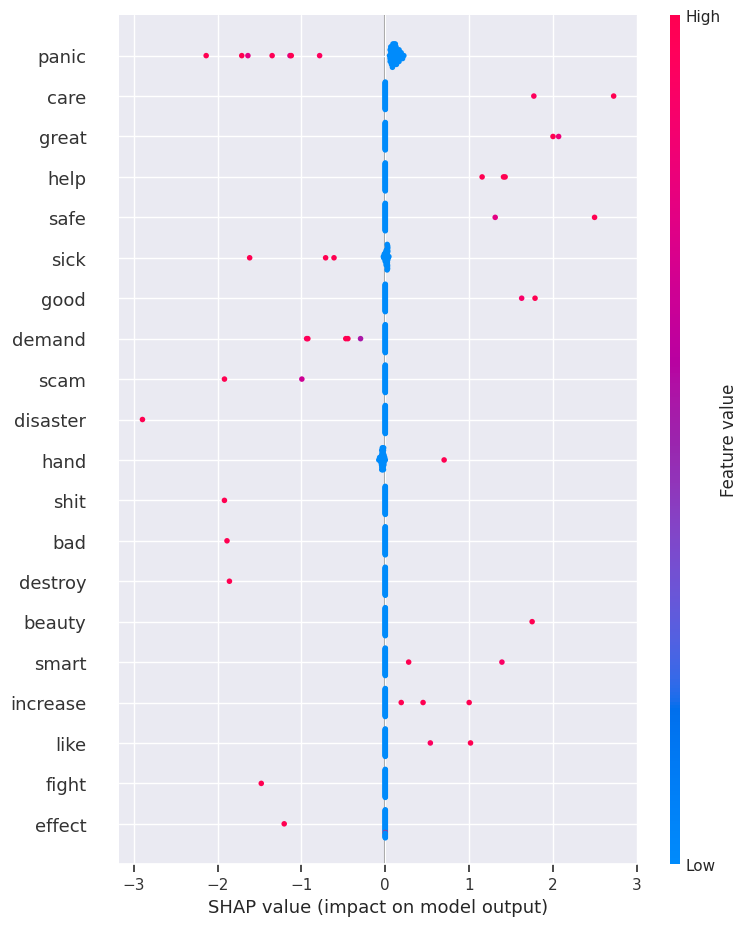

In [26]:
shap.summary_plot(shap_lgb_values_test, X_test_nlp_samp_df,
            plot_type="dot", feature_names=tfidf_vect.get_feature_names_out())

From this plot, we can conclude that words commonly associated with distress or negativity such as "panic," "scam," and "disaster" are influential in driving the model's predictions in one direction, likely towards a negative sentiment. On the other hand, words like "care," "great," and "help" push the prediction in the other direction, which might be towards a positive sentiment.

## Deep Learning

In [59]:
# Converting to list of strings
train_texts = df_train.tweet.apply(lambda x: str(x)).tolist()
valid_texts = df_valid.tweet.apply(lambda x: str(x)).tolist()
test_texts = df_test.tweet.apply(lambda x: str(x)).tolist()

# Converting to list of labels (int)
train_labels = df_train.sentiment_n.tolist()
valid_labels = df_valid.sentiment_n.tolist()
test_labels = df_test.sentiment_n.tolist()

In [60]:
# Vectorize these text samples into a 2D integer tensor using Keras Tokenizer 

MAX_NUM_WORDS = 20000 
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS) 
tokenizer.fit_on_texts(train_texts) 
train_sequences = tokenizer.texts_to_sequences(train_texts) #Converting text to a vector of word indexes
valid_sequences = tokenizer.texts_to_sequences(valid_texts) 
test_sequences = tokenizer.texts_to_sequences(test_texts)
word_index = tokenizer.word_index 
print('Found %s unique tokens.' % len(word_index))

Found 34194 unique tokens.


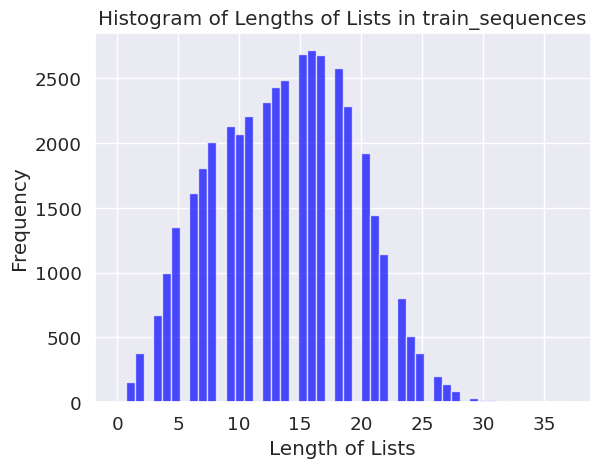

In [61]:
lengths = [len(seq) for seq in train_sequences]

# Create histogram
plt.hist(lengths, bins=50, color='blue', alpha=0.7)
plt.xlabel('Length of Lists')
plt.ylabel('Frequency')
plt.title('Histogram of Lengths of Lists in train_sequences')
plt.grid(True)
plt.show()

In [62]:
MAX_LEN = 35
train_data = pad_sequences(sequences=train_sequences, maxlen=MAX_LEN, padding='post', truncating='post', value = 0.0)
valid_data = pad_sequences(sequences=valid_sequences, maxlen=MAX_LEN, padding='post', truncating='post', value = 0.0)
test_data = pad_sequences(sequences=test_sequences, maxlen=MAX_LEN, padding='post', truncating='post', value = 0.0)
train_data[1], valid_data[1], test_data[1]

(array([1188, 2413, 1897,  257,   94,   19,  114, 1326, 6295,  862,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0], dtype=int32),
 array([ 630, 1844,    1,  313,   80,  160,   49, 1073,  111,  440,   48,
           5,   44,   49,  249,    1,  839, 2680, 1041, 2361, 1844, 3549,
         977,  369,   21,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0], dtype=int32),
 array([  51,    8,   10, 3820, 4353,  292,  265,  363,  345,  148,    1,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0], dtype=int32))

In [63]:
train_labels = to_categorical(np.asarray(train_labels))
valid_labels = to_categorical(np.asarray(valid_labels))
test_labels = to_categorical(np.asarray(test_labels))
train_labels[1] , valid_labels[1], test_labels[1]

(array([0., 1., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0.]))

In [64]:
x_train = train_data
y_train = train_labels
x_val = valid_data
y_val = valid_labels
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((42367, 35), (42367, 5), (10275, 35), (10275, 5))

### GloVe Embeddings

In [65]:
GLOVE_DIR = "/kaggle/input/glove-data"

EMBEDDING_DIM = 100 

print('Preparing embedding matrix.')
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))

Preparing embedding matrix.
Found 400000 word vectors in Glove embeddings.


In [66]:
# prepare embedding matrix - rows are the words from word_index, columns are the embeddings of that word from glove.
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [67]:
# load these pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed during training
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
#                             input_length=MAX_LEN,
                            trainable=False)
print("Preparing of embedding matrix is done")

Preparing of embedding matrix is done


### CNN With own embedding layer

In [80]:
# Define the number of classes
NUM_CLASSES = len(labels_index)

# Initialize the CNN model
cnnmodel = Sequential()

# Add an embedding layer
cnnmodel.add(Embedding(MAX_NUM_WORDS, 128))

# Add convolutional layers with appropriate padding
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(2))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(2))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())

# Add fully connected layers
cnnmodel.add(Dense(128, activation='relu'))
cnnmodel.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
cnnmodel.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

# Train the model
cnnmodel.fit(x_train, y_train,
              batch_size=128,
              epochs=3,
              validation_data=(x_val, y_val))

# Evaluate the model on the test set
score, acc = cnnmodel.evaluate(test_data, test_labels)
print('Test accuracy with CNN:', acc)

Epoch 1/3
331/331 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.3874 - loss: 1.3833 - val_accuracy: 0.6312 - val_loss: 0.9795
Epoch 2/3
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7313 - loss: 0.7252 - val_accuracy: 0.6912 - val_loss: 0.8488
Epoch 3/3
331/331 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8103 - loss: 0.5427 - val_accuracy: 0.6816 - val_loss: 0.8933
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6436 - loss: 1.0018
Test accuracy with CNN: 0.6480358839035034


Model is overfitting

In [74]:
labels_index = {'Extremely Positive': 4, 'Positive': 3, 'Neutral': 2, 'Negative': 1, 'Extremely Negative': 0}
# Define the class labels
labels = list(labels_index.keys())

y_pred = cnnmodel.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded test labels back to categorical labels
test_labels_categorical = np.argmax(test_labels, axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(test_labels_categorical, y_pred_classes, target_names=labels_index.keys()))

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
                    precision    recall  f1-score   support

Extremely Positive       0.75      0.50      0.60       592
          Positive       0.55      0.69      0.61      1041
           Neutral       0.71      0.67      0.69       614
          Negative       0.59      0.68      0.63       947
Extremely Negative       0.84      0.59      0.69       599

          accuracy                           0.64      3793
         macro avg       0.69      0.63      0.65      3793
      weighted avg       0.66      0.64      0.64      3793



The model seems to have the best precision for the "Extremely Negative" class and the best recall for the "Positive" class. The classes "Extremely Positive" and "Extremely Negative" tend to have higher precision, suggesting that when the model predicts these classes, it is often correct, but it doesn't catch all instances (lower recall). Conversely, the "Positive" class, while having a lower precision, has a higher recall, indicating the model captures most of the "Positive" instances but at the cost of more false positives.

### with GloVe embedding layer

In [77]:
# Define the number of classes
NUM_CLASSES = len(labels_index)

# Initialize the CNN model
cnnmodel = Sequential()

# Add an embedding layer
cnnmodel.add(embedding_layer)

# Add convolutional layers with appropriate padding
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(2))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(2))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())

# Add fully connected layers
cnnmodel.add(Dense(128, activation='relu'))
cnnmodel.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
cnnmodel.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

# Train the model
cnnmodel.fit(x_train, y_train,
              batch_size=128,
              epochs=3,
              validation_data=(x_val, y_val))

# Evaluate the model on the test set
score, acc = cnnmodel.evaluate(test_data, test_labels)
print('Test accuracy with CNN:', acc)

Epoch 1/3
331/331 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.5085 - loss: 1.1681 - val_accuracy: 0.6520 - val_loss: 0.9121
Epoch 2/3
331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7238 - loss: 0.7324 - val_accuracy: 0.6685 - val_loss: 0.8936
Epoch 3/3
331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7746 - loss: 0.6164 - val_accuracy: 0.6825 - val_loss: 0.8785
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6486 - loss: 0.9488
Test accuracy with CNN: 0.6569997072219849


In [79]:
labels_index = {'Extremely Positive': 4, 'Positive': 3, 'Neutral': 2, 'Negative': 1, 'Extremely Negative': 0}
# Define the class labels
labels = list(labels_index.keys())

y_pred = cnnmodel.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded test labels back to categorical labels
test_labels_categorical = np.argmax(test_labels, axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(test_labels_categorical, y_pred_classes, target_names=labels_index.keys()))

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
                    precision    recall  f1-score   support

Extremely Positive       0.76      0.58      0.66       592
          Positive       0.57      0.71      0.64      1041
           Neutral       0.75      0.68      0.71       614
          Negative       0.63      0.58      0.60       947
Extremely Negative       0.70      0.75      0.72       599

          accuracy                           0.66      3793
         macro avg       0.68      0.66      0.67      3793
      weighted avg       0.67      0.66      0.66      3793



Accuracy has slightly improved. Macro and weighted averages for precision, recall, and F1-score have improved, indicating better overall performance across all classes. The updated model has shown marked progress in correctly identifying the more nuanced "Extremely Positive" and "Extremely Negative" sentiment classes, which are often more difficult for sentiment analysis models to distinguish. Despite a slight decrease in precision for "Extremely Negative", the model has improved in its ability to recognize true cases of this class. Overall, the model has demonstrated enhanced performance and balance across all sentiment classes, indicated by higher accuracy and F1-scores, suggesting its increased proficiency in accurately classifying sentiments across the dataset.

Could use RNN to capture more context.

### Transformer-based model

In [83]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [84]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [85]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(MAX_LEN,))
embedding_layer = TokenAndPositionEmbedding(MAX_LEN, MAX_NUM_WORDS, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x) 

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val)
)

Epoch 1/2
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.4262 - loss: 1.2950 - val_accuracy: 0.6741 - val_loss: 0.8681
Epoch 2/2
1324/1324 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7671 - loss: 0.6476 - val_accuracy: 0.6846 - val_loss: 0.8564


In [86]:
#Evaluate on test set:
score, acc = model.evaluate(test_data, test_labels)
print('Test accuracy with Transformer based model:', acc)

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6482 - loss: 0.9614
Test accuracy with Transformer based model: 0.6572633981704712


Slightly higher accuracy.

## The END

For future iterations of the project, the following improvements and recommendations could be considered:

- Tailor the model to the specific needs of the business scenario at hand, focusing on the **most critical classes** for accuracy improvement. This could involve collaborating closely with domain experts to understand which misclassifications are most costly or harmful.

- Reduce the number of classes by combining "Positive" with "Extremely Positive" and "Negative" with "Extremely Negative". This simplification could improve the model's performance by reducing the complexity of the classification task. To address class imbalance, augment data for underrepresented classes that would be neutral in this case. 

- Leverage pre-trained models such as https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest from Hugging Face's model repository. These models, already fine-tuned on similar data, can provide a strong starting point and may yield better performance out-of-the-box compared to training a model from scratch.

- Conduct a thorough error analysis to understand the types of misclassifications occurring and refine the preprocessing, feature engineering, or model architecture accordingly.